In [351]:
import numpy as np
from tic_env import TictactoeEnv, OptimalPlayer
from tqdm import tqdm
from collections import defaultdict
import random
import matplotlib.pyplot as plt

In [2]:
def tuple_to_int(action):
    return action[0] * 3 + action[1]

def int_to_tuple(position):
    return (int(position/3), position % 3)

In [335]:
class QPlayer:
    def __init__(self, epsilon=0.2, alpha=0.05, gamma=0.99, player='X', explore = False, e_min = 0.1, e_max = 0.8, n_star = 20000):
        self.epsilon = epsilon
        self.player = player # 'x' or 'O'
        self.alpha = alpha
        self.gamma = gamma
        # 3^9 states 9 length vectors are keys and 9 length list of values represents actions 
        self.Qvalues = defaultdict(lambda: [0 for _ in range(9)]) 
        self.last_action = 0
        self.last_state = 0
        self.player2value = {'X': 1, 'O': -1}
        self.counter = 0
        self.explore = explore
        self.e_min = e_min
        self.e_max = e_max
        self.n_star = n_star

    def empty(self, grid):
        '''return all empty positions'''
        avail = []
        for i in range(9):
            pos = (int(i/3), i % 3)
            if grid[pos] == 0:
                avail.append(pos)
        return avail

    def randomMove(self, grid):
        """ Chose a random move from the available options. """
        avail = self.empty(grid)
        return avail[random.randint(0, len(avail)-1)]

    def act(self, grid):
        if self.explore:
            self.epsilon = self.decreasing_exploration(self.e_min, self.e_max, self.n_star, self.counter)
        # epsilon greedy policy w.r.t. Q-values
        if random.random() < self.epsilon:
            action = self.randomMove(grid)
            self.last_action = tuple_to_int(action)
        else:
            idx = np.argmax([self.Qvalues[str(grid)][tuple_to_int(pos)] for pos in self.empty(grid)])
            action = self.empty(grid)[idx]
            self.last_action = tuple_to_int(action)

        self.last_state = str(grid)  
        return action

    def updateQ(self, grid, end, winner):
        if (end == True):
            off_policy = 0
            if winner == self.player: 
                reward = 1 
            else: 
                reward = -1
        else:
            reward = 0
            off_policy = max([self.Qvalues[str(grid)][tuple_to_int(pos)] for pos in self.empty(grid)])
        self.Qvalues[self.last_state][self.last_action] += self.alpha * (reward + self.gamma * off_policy - self.Qvalues[self.last_state][self.last_action]) 
    
    def decreasing_exploration(self, e_min, e_max, n_star, n):
        return max(e_min, e_max * (1 - n/n_star)) 
            

In [353]:
def play_game(agent1, agent2, env, i, train):
    grid, end, __  = env.observe()
    if i % 2 == 0:
        agent1.player = 'X'
        agent2.player = 'O'
    else:
        agent1.player = 'O'
        agent2.player = 'X'
        move = agent2.act(grid)
        grid, end, winner = env.step(move, print_grid=False)
    while end == False:
        if env.current_player == agent1.player:
            move = agent1.act(grid)
            grid, end, winner = env.step(move, print_grid=False)  
            if end and train:
                agent1.updateQ(grid.copy(), end, winner)
        else:
            move = agent2.act(grid)
            grid, end, winner = env.step(move, print_grid=False)
            if train:
                agent1.updateQ(grid.copy(), end, winner)
    return winner, agent1, agent2

def simulate(agent1, agent2, N=500, train=True, bar=True):
    env = TictactoeEnv()
    N_win = 0
    N_loose = 0
    history = []
    
    for i in tqdm(range(N), disable=not bar):
        # initialize env and players
        env.reset()
        agent1.counter += 1
        # simulation
       
        winner, agent1, agent2 = play_game(agent1, agent2, env, i, train)

        # save results
        if winner == agent1.player:
            N_win += 1
            history.append(1)
        elif winner == agent2.player:
            N_loose += 1
            history.append(-1)
        else:
            history.append(0)
           
    return history, (N_win - N_loose) / N, agent1
            


Q1

Observations: when our agent is with 'X' it performs well, but with 'O' it struggles a lot. I have no idea what is happening there....

100%|██████████| 20000/20000 [03:06<00:00, 107.12it/s]


0.16135


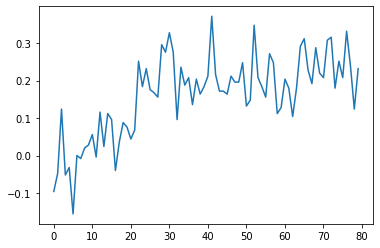

In [342]:
agent1 = QPlayer(epsilon=0.1)
agent2 = OptimalPlayer(epsilon=0.5)
env = TictactoeEnv()
history, metric, agent1 = simulate(agent1, agent2, N=20000)
print(metric)
results = np.mean(np.array(history).reshape(80,250), axis=1)
plt.plot(results)

Q2

In [355]:
agent1 = QPlayer(explore= True, n_star=1)
agent2 = QPlayer(explore= True, n_star=1000)
agent3 = QPlayer(explore= True, n_star=10000)
agent4 = QPlayer(explore= True, n_star=20000)
agent5 = QPlayer(explore= True, n_star=40000)
opponent = OptimalPlayer(epsilon=0.5)
env = TictactoeEnv()
history1, metric, agent1 = simulate(agent1, opponent, N=20000)
print(metric)
history2, metric, agent2 = simulate(agent2, opponent, N=20000)
print(metric)
history3, metric, agent3 = simulate(agent3, opponent, N=20000)
print(metric)
history4, metric, agent4 = simulate(agent4, opponent, N=20000)
print(metric)
history5, metric, agent5 = simulate(agent4, opponent, N=20000)
print(metric)

100%|██████████| 20000/20000 [03:02<00:00, 109.62it/s]


0.13815


100%|██████████| 20000/20000 [02:55<00:00, 113.69it/s]


0.1399


100%|██████████| 20000/20000 [02:46<00:00, 120.00it/s]


0.0635


100%|██████████| 20000/20000 [02:36<00:00, 127.86it/s]


-0.0602


100%|██████████| 20000/20000 [02:56<00:00, 113.16it/s]

0.3266


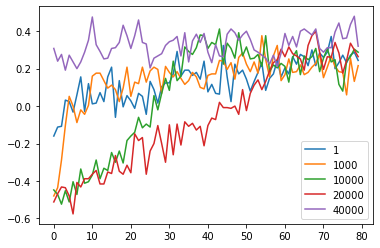

In [359]:
results1 = np.mean(np.array(history1).reshape(80,250), axis=1)
results2 = np.mean(np.array(history2).reshape(80,250), axis=1)
results3 = np.mean(np.array(history3).reshape(80,250), axis=1)
results4 = np.mean(np.array(history4).reshape(80,250), axis=1)
results5 = np.mean(np.array(history5).reshape(80,250), axis=1)
plt.plot(results1, label='1')
plt.plot(results2, label='1000')
plt.plot(results3, label='10000')
plt.plot(results4, label='20000')
plt.plot(results5, label='40000')
plt.legend()

Q3

In [349]:
def Q3(agent1, agent2, N=80):
    m_opts = []
    m_rands = []
    agent_opt = OptimalPlayer(epsilon = 0)
    agent_rand = OptimalPlayer(epsilon = 1)
    
    for i in tqdm(range(N)):
        # training phase
        _, __, agent1 = simulate(agent1, agent2, N=250, train=True, bar=False)
        # testing phase
        _, m_opt, agent1 = simulate(agent1, agent_opt, N=500, train=False, bar=False)
        _, m_rand, agent1 = simulate(agent1, agent_rand, N=500, train=False, bar=False)
        #save results
        m_opts.append(m_opt)
        m_rands.append(m_rand)
           
    return m_opts, m_rands
            

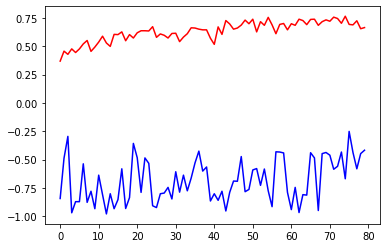

In [348]:
agent4 = QPlayer(explore= True, n_star=20000)
agent2 = OptimalPlayer(epsilon=0.5)
m_opts, m_rands = Q3(agent1, agent2, N=80)
plt.plot(m_opts, color='blue')
plt.plot(m_rands, color='red')

Q4

Q5

Q6